In [1]:
import pandas as pd
import numpy as np
from src.utils import extend_df
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from src.utils import predict_and_plot

In [2]:
raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

assert 'Surname' in raw_df.columns, "Surname column not found in dataset."
# raw_df.drop(columns=['Surname'], inplace=True)
raw_df['Surname'] = raw_df['Surname'].apply(lambda x: x[1])

intersections = [
    ('Age', 'Balance'),
    ('Age', 'NumOfProducts'),
    ('Age', 'EstimatedSalary'),
    ('Age', 'CreditScore'),
]
logarithms = [
    'Age',
    'Balance',
    'EstimatedSalary',
    'AgeCreditScoreInteraction',
    'AgeNumOfProductsInteraction',
]
squares = [
    'Age',
    'AgeBalanceInteraction'
]
raw_df = extend_df(raw_df, intersections, logarithms, squares)

In [3]:
# Create train and validation data sets
input_cols = raw_df.drop(columns=['CustomerId', 'Exited']).columns
target_col = raw_df[['Exited']].columns[0]
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df[target_col])
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numerical and categorical columns
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(['object', 'category']).columns.tolist()

Area under ROC score on Training Poly dataset: 93.72%


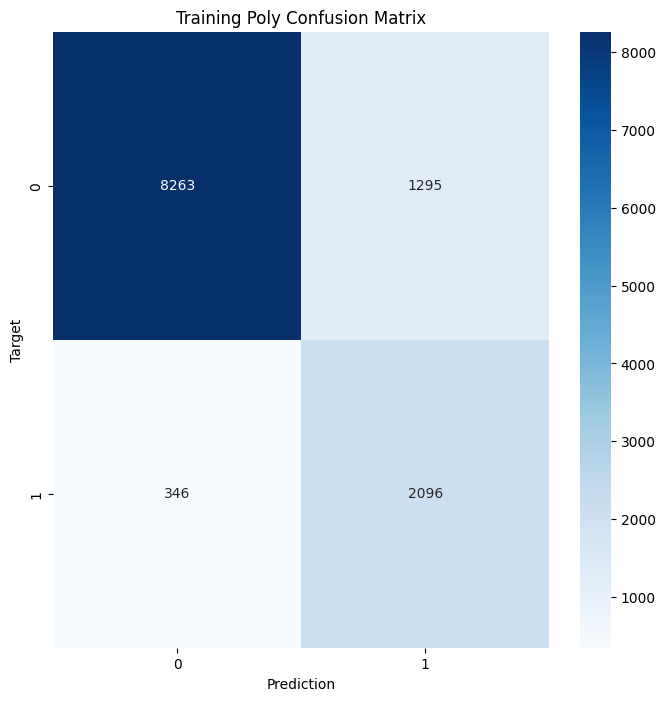

Area under ROC score on Validation Poly dataset: 93.66%


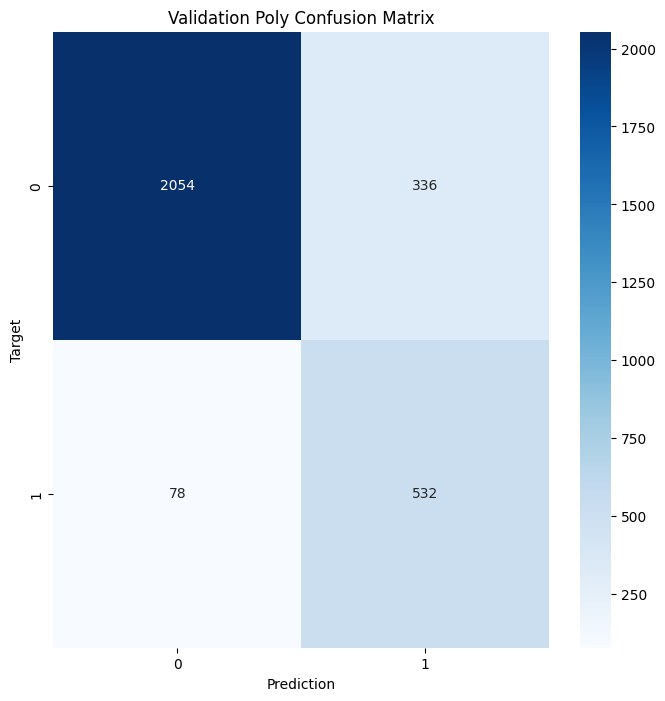

In [4]:
numeric_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver="liblinear", class_weight='balanced', penalty="l1", C=0.5))
])

model_pipeline.fit(train_inputs, train_targets)

train_preds_poly_3 = predict_and_plot(model_pipeline, train_inputs, train_targets, "Training Poly")
val_preds_poly_3 = predict_and_plot(model_pipeline, val_inputs, val_targets, "Validation Poly")

In [5]:
from src.utils import gen_submission_sample

test_raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/test.csv")
test_raw_df = extend_df(test_raw_df, intersections, logarithms, squares)
gen_submission_sample(model_pipeline, test_raw_df)